### Mounting google drive

In [ ]:
import os
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
os.getcwd()

'/gdrive'

In [ ]:

os.chdir("./MyDrive/GRABMYO_analysis")
!pwd


/gdrive/.shortcut-targets-by-id/1tw9Hs0Or0znsWRSy_DDwzaFMCaeOMVQ1/GRABMYO_analysis


In [ ]:
import scipy.io
import numpy as np
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, Add, Activation
from tensorflow.keras.layers import MaxPooling2D, Dropout, MaxPooling1D
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import SGD, RMSprop
from matplotlib import pyplot as plt


In [ ]:
def load_data():
    emg_data = []
    for day in range(1, 4): # range(1, 4) for reading all the data files
        fnames = "data_old/wrist_fdt_day" + str(day) + ".mat"
        mat = scipy.io.loadmat(fnames)
        emg_data.append(mat.get("FeatSet"))

    emg_data = np.array(emg_data)
    print('EMG_DATA SHAPE: ', emg_data.shape)

    print("Data has:       ", str(emg_data.shape[0]), "Days", str(emg_data.shape[1]), "Subjects",
          str(emg_data.shape[2]),
          "Gestures")
    print("Each Day has:   ", str(emg_data.shape[0]), "x", str(emg_data.shape[1]), "=",
          str(emg_data.shape[0] * emg_data.shape[1]), "Trials")
    print("Each Trial has: ", str(emg_data[0, 0, 0].shape[0]), "Samples", str(emg_data[0, 0, 0].shape[1]), "Features")
    return emg_data
emg_data = load_data()

EMG_DATA SHAPE:  (3, 43, 16)
Data has:        3 Days 43 Subjects 16 Gestures
Each Day has:    3 x 43 = 129 Trials
Each Trial has:  233 Samples 36 Features


In [ ]:
# Full dataset with 16 gestures. Run this if you want to save again for any reason
# scipy.io.savemat('data_old/data_16.mat', {'feat': emg_data})

In [ ]:
fname = "data_old/data_16.mat"
mat = scipy.io.loadmat(fname)
dataset = mat.get("feat")

In [ ]:
dataset[0, 0, 0][:198,:]

array([[2.65139609, 2.54119286, 2.07307359, ..., 2.22511634, 1.30342873,
        0.90668038],
       [2.63082514, 2.63139847, 2.1130344 , ..., 2.19689839, 1.41717658,
        0.91217265],
       [2.84539015, 2.57641485, 1.93142993, ..., 1.93552243, 1.48158315,
        0.75601109],
       ...,
       [2.23623896, 2.56753456, 1.93935   , ..., 2.15060425, 1.21866407,
        0.92939764],
       [2.19671437, 2.45620261, 2.10428743, ..., 2.0365478 , 1.22656677,
        0.77670642],
       [2.28179063, 2.5879185 , 1.85425655, ..., 1.65154408, 1.09122253,
        0.58322911]])

In [ ]:
# sandwich the data
# the original_matrix with shape (3, 43, 16) and each cell containing elements of shape (233, 36)

# Crete new matrix with the shape (43, 16, 699, 36)
train_X = np.empty((43, 16, 198*3, 36))
test_X = np.empty((43, 16, 33*3, 36))
train_y = np.empty((43, 16, 198*3))
test_y = np.empty((43, 16, 33*3))

# Iterate through each cell in the original matrix
for i in range(43):
    for j in range(16):
        # Concatenate the elements from dimensions 0, 1, and 2 along the second dimension (699)
        train_X[i, j] = np.concatenate(
            (dataset[0, i, j][:198, :], dataset[1, i, j][:198, :], dataset[2, i, j][:198, :]),
            axis=0
        )
        test_X[i, j] = np.concatenate(
            (dataset[0, i, j][-33:,:], dataset[1, i, j][-33:,:], dataset[2, i, j][-33:,:]),
            axis=0
        )
        train_y[i, j]= [j+1]*198*3
        test_y[i, j]= [j+1]*33*3


In [ ]:
 print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(43, 16, 594, 36) (43, 16, 99, 36) (43, 16, 594) (43, 16, 99)


In [ ]:
print(train_X[0,0, 593, :])
print(test_X[0,0, 98, :])
print(train_y[0,0, 593])
print(test_y[0,0, 98])

[2.06453373 1.95044761 1.4232321  1.30671771 1.01049462 0.60112307
 1.90315423 1.8581015  1.14838035 1.43185932 1.11272862 0.53269401
 1.62691114 1.60003913 1.25019617 1.35439348 0.98212543 0.54407479
 2.20018723 2.12726507 1.44248358 1.26017682 0.82359085 0.34694735
 2.26237146 2.09706364 1.4766995  1.70296204 1.21042489 0.90075721
 1.94831655 2.05942431 1.65179593 1.89841448 1.51069852 0.89702174]
[1.42330269 1.95402081 1.56311271 1.12505621 1.08082345 0.40725135
 1.52992395 1.58990013 1.73284055 1.43373991 0.75005624 0.63837766
 1.04835942 1.73237323 1.46661771 1.17572116 0.93150582 0.72072272
 1.46781847 1.76348239 1.42127244 1.26638381 1.14529476 0.58581783
 1.20660015 1.65772128 1.25737047 0.92582145 0.86119329 0.8599232
 1.02688391 1.57664514 1.85337874 1.60991272 1.3494485  0.86207734]
1.0
1.0


In [ ]:
 # reshape data NEED TO BE UPDATED
  # trainX = trainX.reshape((trainX.shape[0]*trainX.shape[1]), trainX.shape[2])
  # testX = testX.reshape((testX.shape[0]*testX.shape[1]), testX.shape[2])

  # lb = LabelBinarizer()
  # train_y = lb.fit_transform(train_y)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
  # test_y = lb.transform(test_y)

In [ ]:
# CNN model
def define_model_conv1d(n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(36, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    return model

In [ ]:
n = 43  # Number of participants
cnn_models = []  # List to store the models
histories = list()

for _ in range(n):
    model = define_model_conv1d(16)
    cnn_models.append(model)

In [ ]:
def normalize_data(data):
    # Calculate mean and standard deviation along each channel
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    # Normalize the data by subtracting the mean and dividing by the standard deviation
    normalized_data = (data - mean) / std

    return normalized_data

In [ ]:
# train for each participant
for i in range(43):
  trX = train_X[i, :]
  trY = train_y[i, :]
  teX = test_X[i, :]
  teY = test_y[i, :]

  trX = trX.reshape((trX.shape[0]*trX.shape[1]), trX.shape[2])
  trY = trY.reshape((trY.shape[0]*trY.shape[1]))

  teX = teX.reshape((teX.shape[0]*teX.shape[1]), teX.shape[2])
  teY = teY.reshape((teY.shape[0]*teY.shape[1]))

  lb = LabelBinarizer()
  trY = lb.fit_transform(trY)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
  teY = lb.transform(teY)

  print(trX.shape, teX.shape, trY.shape, teY.shape)

  # normalize data
  trX = normalize_data(trX)
  teX = normalize_data(teX)

  model = cnn_models[i]
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(trX, trY, epochs=50, batch_size=32, validation_data=(teX, teY))
  histories.append(history)

  print(f"END of training for model {i}")


(9504, 36) (1584, 36) (9504, 16) (1584, 16)
Epoch 1/50
297/297 [==============================] - 12s 6ms/step - loss: 1.5241 - accuracy: 0.5174 - val_loss: 0.9742 - val_accuracy: 0.6717
Epoch 2/50
297/297 [==============================] - 1s 4ms/step - loss: 0.8614 - accuracy: 0.7105 - val_loss: 0.8045 - val_accuracy: 0.7361
Epoch 3/50
297/297 [==============================] - 1s 4ms/step - loss: 0.7064 - accuracy: 0.7614 - val_loss: 0.7579 - val_accuracy: 0.7494
Epoch 4/50
297/297 [==============================] - 1s 4ms/step - loss: 0.6201 - accuracy: 0.7841 - val_loss: 0.7518 - val_accuracy: 0.7569
Epoch 5/50
297/297 [==============================] - 1s 4ms/step - loss: 0.5728 - accuracy: 0.8058 - val_loss: 0.7536 - val_accuracy: 0.7557
Epoch 6/50
297/297 [==============================] - 2s 6ms/step - loss: 0.5291 - accuracy: 0.8140 - val_loss: 0.7224 - val_accuracy: 0.7708
Epoch 7/50
297/297 [==============================] - 2s 7ms/step - loss: 0.4944 - accuracy: 0.8220 - v

Subject 0 - Accuracy 0.7727272510528564
Subject 1 - Accuracy 0.7796717286109924
Subject 2 - Accuracy 0.8005050420761108
Subject 3 - Accuracy 0.810606062412262
Subject 4 - Accuracy 0.8491161465644836
Subject 5 - Accuracy 0.7765151262283325
Subject 6 - Accuracy 0.8118686676025391
Subject 7 - Accuracy 0.7891414165496826
Subject 8 - Accuracy 0.8087121248245239
Subject 9 - Accuracy 0.7878788113594055
Subject 10 - Accuracy 0.818813145160675
Subject 11 - Accuracy 0.8402777910232544
Subject 12 - Accuracy 0.8270202279090881
Subject 13 - Accuracy 0.7020202279090881
Subject 14 - Accuracy 0.754419207572937
Subject 15 - Accuracy 0.8661616444587708
Subject 16 - Accuracy 0.9368686676025391
Subject 17 - Accuracy 0.8844696879386902
Subject 18 - Accuracy 0.8358585834503174
Subject 19 - Accuracy 0.8238636255264282
Subject 20 - Accuracy 0.7449495196342468
Subject 21 - Accuracy 0.8276515007019043
Subject 22 - Accuracy 0.8503788113594055
Subject 23 - Accuracy 0.8743686676025391
Subject 24 - Accuracy 0.81502

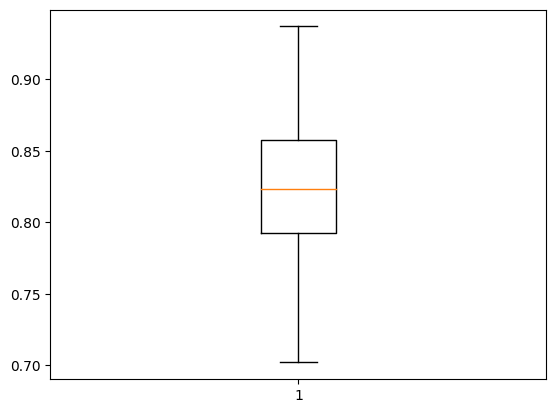

In [ ]:
for i in range(len(histories)):
  print(f"Subject {i} - Accuracy {histories[i].history['val_accuracy'][49]}")

# Box plot
scores = []
for row in histories:
  scores.append(row.history['val_accuracy'][49])

# Get the median from the statistical summary
median = plt.boxplot(scores)['medians'][0].get_ydata()[0]

print(f"Median: {median}")

In [ ]:
# RUN THIS IF RE-TRAINING from scratch
# Save model for future training

# # serialize model to JSON
# for i in range(n):
#   model_json = cnn_models[i].to_json()
#   with open(f"models/model_{i}.json", "w") as json_file:
#       json_file.write(model_json)

#   # serialize weights to HDF5
#   cnn_models[i].save_weights(f"models/model_{i}.h5")
#   print(f"Saved model {i} to disk")

Saved model 0 to disk
Saved model 1 to disk
Saved model 2 to disk
Saved model 3 to disk
Saved model 4 to disk
Saved model 5 to disk
Saved model 6 to disk
Saved model 7 to disk
Saved model 8 to disk
Saved model 9 to disk
Saved model 10 to disk
Saved model 11 to disk
Saved model 12 to disk
Saved model 13 to disk
Saved model 14 to disk
Saved model 15 to disk
Saved model 16 to disk
Saved model 17 to disk
Saved model 18 to disk
Saved model 19 to disk
Saved model 20 to disk
Saved model 21 to disk
Saved model 22 to disk
Saved model 23 to disk
Saved model 24 to disk
Saved model 25 to disk
Saved model 26 to disk
Saved model 27 to disk
Saved model 28 to disk
Saved model 29 to disk
Saved model 30 to disk
Saved model 31 to disk
Saved model 32 to disk
Saved model 33 to disk
Saved model 34 to disk
Saved model 35 to disk
Saved model 36 to disk
Saved model 37 to disk
Saved model 38 to disk
Saved model 39 to disk
Saved model 40 to disk
Saved model 41 to disk
Saved model 42 to disk
